In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sys
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from statistics import mean
from sklearn.preprocessing import LabelEncoder




# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


In [2]:
def correct_indexing(dataset):
    dataset.insert(0, 'index', range(0, len(dataset)))
    dataset.set_index("index", inplace = True)
    return

In [3]:
dataset = pd.read_csv("../input/credit-card-customers/BankChurners.csv")
dataset.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1, inplace = True)

dataset['Attrition_Flag'].replace({'Existing Customer' : 1, 'Attrited Customer' : 0}, inplace = True)
dataset['Gender'].replace({'M' : 1, 'F' : 0}, inplace = True)
dataset['Education_Level'].replace({'Uneducated' : 0, 'Unknown' : -1, 'High School' : 1, 'College' : 2, 'Graduate' : 3, 'Post-Graduate' : 4, 'Doctorate' : 5}, inplace = True)
dataset['Marital_Status'].replace({'Married' : 1, 'Single' : 0, 'Divorced' : 2, 'Unknown' : -1}, inplace = True)
dataset['Income_Category'].replace({'Unknown' : -1, 'Less than $40K' : 1, '$40K - $60K' : 2, '$60K - $80K' : 3, '$80K - $120K' : 4, '$120K +' : 5}, inplace = True)
dataset['Card_Category'].replace({'Blue' : 0, 'Silver' : 1, 'Gold' : 2, 'Platinum' : 3}, inplace = True)

dataset.drop(dataset[dataset['Education_Level'] == -1 ].index, inplace = True)
dataset.drop(dataset[dataset['Income_Category'] == -1 ].index, inplace = True)
dataset.drop(dataset[dataset['Marital_Status'] == -1 ].index, inplace = True)
dataset = dataset.dropna()
correct_indexing(dataset)

dataset.head(5)



,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
index,,,,,,,,,,,,,,,,,,,,
0,1,45,1,3,1,1,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,0,5,3,0,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,1,3,3,1,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,1,3,0,1,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
4,1,44,1,2,3,1,2,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311


In [4]:
def catagory_churn_unchurn(type_of_card, data):
    dataset_card = data[data['Card_Category'] == type_of_card]
    correct_indexing(dataset_card)
    return dataset_card

blue = catagory_churn_unchurn(0, dataset)
silver = catagory_churn_unchurn(1, dataset)
gold = catagory_churn_unchurn(2, dataset)
platinum = catagory_churn_unchurn(3, dataset)

In [5]:
dataset.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
index,,,,,,,,,,,,,,,,,,,,
0,1,45,1,3,1,1,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,49,0,5,3,0,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,1,51,1,3,3,1,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,1,40,1,3,0,1,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
4,1,44,1,2,3,1,2,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311


In [6]:
def plotter(column, Group):
    if (column == 'Contacts_Count_12_mon') | (column == 'Total_Revolving_Bal') | (column == 'Total_Trans_Amt') | (column == 'Total_Trans_Ct'):
        plot = pd.crosstab(dataset[column], dataset[Group])
        plot.div(plot.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True) 
        plot1 = pd.crosstab(blue[column], blue[Group])
        plot1.div(plot1.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True) 
        plot2 = pd.crosstab(silver[column], silver[Group])
        plot2.div(plot2.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
        plot3 = pd.crosstab(gold[column], gold[Group])
        plot3.div(plot3.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
        plot4 = pd.crosstab(platinum[column], platinum[Group])
        plot4.div(plot4.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
        plt.show()
    else:
        plot = pd.crosstab(dataset[column], dataset[Group])
        plot.div(plot.sum(1).astype(float), axis = 0).plot(kind = "line", stacked = True)
        plot1 = pd.crosstab(blue[column], blue[Group])
        plot1.div(plot1.sum(1).astype(float), axis = 0).plot(kind = "line", stacked = True)
        plot2 = pd.crosstab(silver[column], silver[Group])
        plot2.div(plot2.sum(1).astype(float), axis = 0).plot(kind = "line", stacked = True)
        plot3 = pd.crosstab(gold[column], gold[Group])
        plot3.div(plot3.sum(1).astype(float), axis = 0).plot(kind = "line", stacked = True)
        plot4 = pd.crosstab(platinum[column], platinum[Group])
        plot4.div(plot4.sum(1).astype(float), axis = 0).plot(kind = "line", stacked = True)
        plt.show()
    return


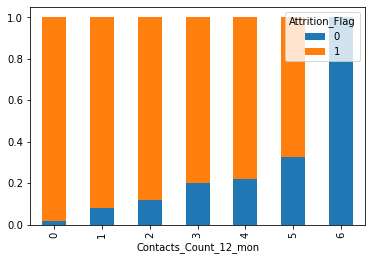

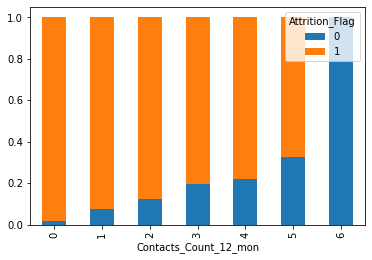

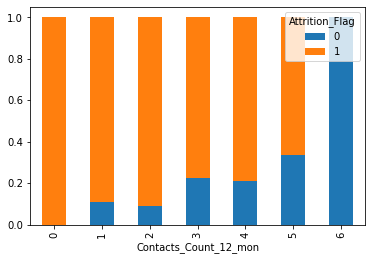

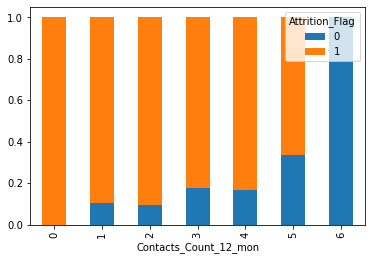

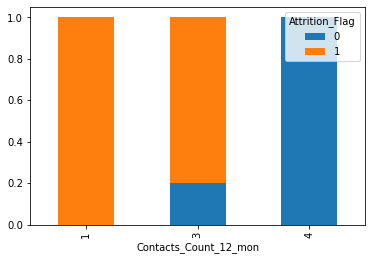

In [7]:
plotter('Contacts_Count_12_mon', 'Attrition_Flag')

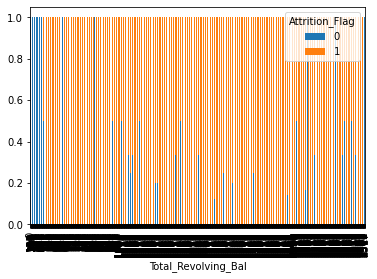

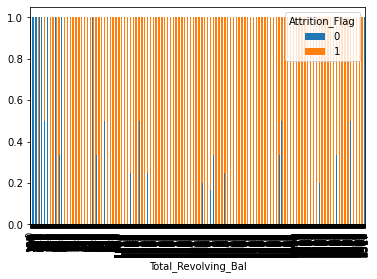

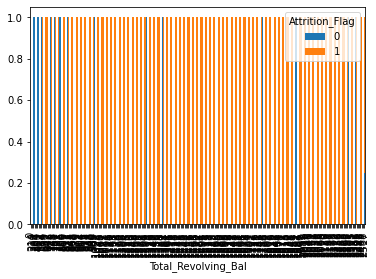

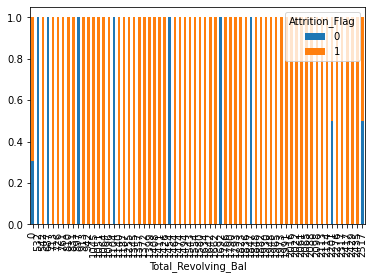

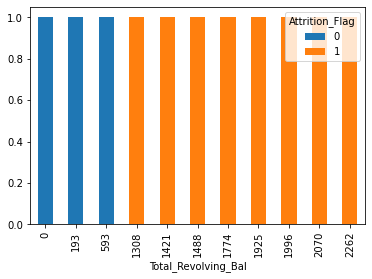

In [8]:
plotter('Total_Revolving_Bal', 'Attrition_Flag')

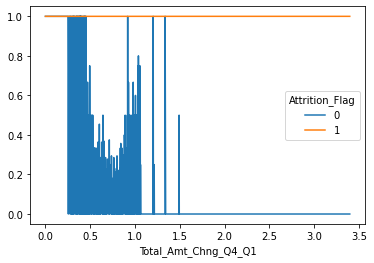

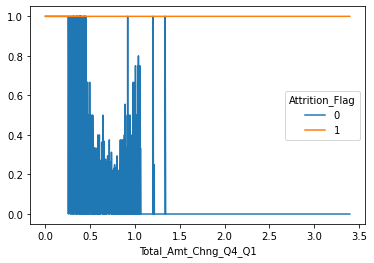

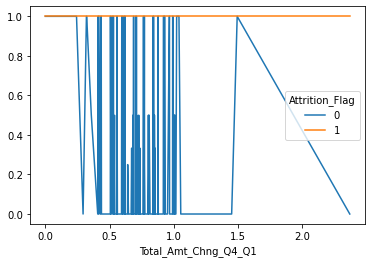

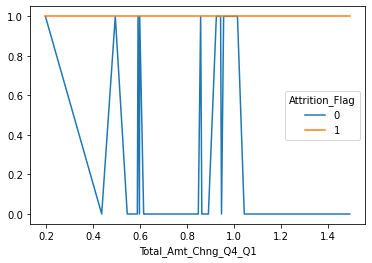

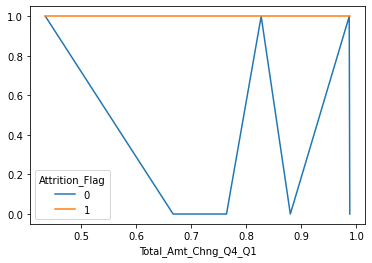

In [11]:
plotter('Total_Amt_Chng_Q4_Q1', 'Attrition_Flag')